# Import Libraries

In [4]:
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import iplot
from termcolor import colored
from statsmodels.graphics.tsaplots import plot_acf

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from category_encoders import OrdinalEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA

# Color pallet and theme
import matplotlib.colors

# Configuration

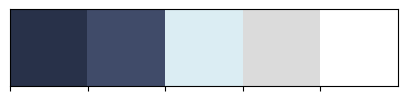

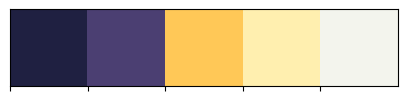

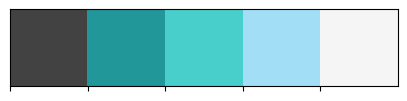

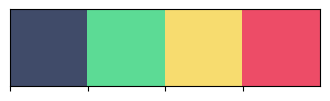

In [5]:
# Colors 1
colors = ["#283149", "#404B69", "#DBEDF3", "#DBDBDB", "#FFFFFF"]
colorsInv = ["#FFFFFF", "#DBDBDB", "#DBEDF3", "#404B69", "#283149"]
palette1 = sns.color_palette(colors)

# Colors 2
colors2 = ["#1F2041", "#4B3F72", "#FFC857", "#FFEFAF", "#F3F4ED"]
colorsInv2 = ["#F3F4ED", "#FFEFAF", "#FFC857", "#4B3F72", "#1F2041"]
palette2 = sns.color_palette(colors2)

# Colors 3
colors3 = ["#424242", "#229799", "#48CFCB", "#A2DFF7", "#F5F5F5"]  
colorsInv3 = ["#F5F5F5", "#A2DFF7", "#48CFCB", "#229799", "#424242"]
palette3 = sns.color_palette(colors3)

# Colors 4
colors4 = ['#404B69', '#5CDB95', '#F7DC6F', '#ED4C67']
colorsInv4 = ['#ED4C67', '#F7DC6F', '#5CDB95', '#404B69']
palette4 = sns.color_palette(colors4)

cmap = matplotlib.colors.ListedColormap(colorsInv)
cmap2 = matplotlib.colors.ListedColormap(colorsInv2)
cmap3 = matplotlib.colors.ListedColormap(colorsInv3)

sns.palplot(sns.color_palette(colors))

sns.palplot(sns.color_palette(colors2))

sns.palplot(sns.color_palette(colors3))

sns.palplot(sns.color_palette(colors4))

pd.set_option('display.max_columns', 40)

# Load Dataset

In [6]:
games = pd.read_csv('../data/games_clean.csv')

In [7]:
games['Release date'] = pd.to_datetime(games['Release date'])

In [8]:
games['Mac'] = games['Mac'].astype(int)

In [9]:
games['Windows'] = games['Windows'].astype(int)

In [10]:
games['Linux'] = games['Linux'].astype(int)

# Feature Engineering

## Functions

In [11]:
def scores_class(features : pd.DataFrame, target : pd.Series, discrete_features : str):
  score_classify = mutual_info_classif(features, target, discrete_features=discrete_features)
  scores = pd.DataFrame({
    'Feature': features.columns,
    'MI Score (Classify)': score_classify
  })
  return scores.sort_values(by = 'MI Score (Classify)', ascending = False)

def count_languages(word : str):
  word.replace("'", '')
  word.replace("[", '').replace("]", '')
  return len(word.split(','))

## Encode - Feature Categorical

In [12]:
categories = []
for i, row in games.iterrows():
    if type(row['Genres'].split(',')) == list:
        for cat in row['Genres'].split(','): categories.append(cat)

print(len(set(categories)))

33


In [13]:
one_hot_encode = pd.DataFrame()

for category in set(categories):
    cat = []
    for _, row in games.iterrows():
        cat.append(np.int64(category in row['Genres'].split(',')))
    one_hot_encode[category] = cat

one_hot_encode.head()

,Sports,Tutorial,Short,Casual,360 Video,Audio Production,Early Access,Violent,Episodic,Accounting,Strategy,Design & Illustration,Nudity,Utilities,Massively Multiplayer,Web Publishing,Simulation,Photo Editing,RPG,Action,Documentary,Free to Play,Indie,Software Training,Racing,Education,Adventure,Movie,Gore,Video Production,Sexual Content,Game Development,Animation & Modeling
0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [14]:
games = pd.concat((games, one_hot_encode), axis = 1)

In [15]:
games = games.drop(columns= ['Genres'])

In [16]:
label_encoder = LabelEncoder()
games['Estimated owners'] = label_encoder.fit_transform(games['Estimated owners'])

## New Features

In [17]:
# Count the number of operating systems the game is available on
games['Platform_count'] = games[['Windows', 'Mac', 'Linux']].sum(axis = 1)

In [18]:
# Number of achievements per hour of playtime
games['Achievements_per_hour'] = games.apply(
    lambda x : 
        x['Achievements'] 
        if x['Average playtime forever'] == 0 
        else x['Achievements'] / x['Average playtime forever'],
    axis = 1
)

In [19]:
# Amount of genres the game is available in
games['Genre_count'] = games[list(set(categories))].sum(axis = 1)

In [20]:
# Ratio of recent playtime to total playtime
games['Recent_playtime_ratio'] = games.apply(
    lambda x : 
        x['Average playtime two weeks'] 
        if x['Average playtime forever'] == 0 
        else x['Average playtime two weeks'] / x['Average playtime forever'],
    axis = 1
)

In [21]:
# Count the number of languages the game is available in
games['Language_count'] = games['Supported languages'].apply(count_languages)

In [22]:
# Ratio of quantity of operating systems the game is available on
games['OS_ratio'] = (games[['Windows', 'Mac', 'Linux']].sum(axis = 1) / 3).astype(float)

In [23]:
# Antiquity of the game
games['Antiquity'] = (pd.to_datetime('today') - games['Release date']).dt.days

In [24]:
# Recommendations user based on the genre
games['Recommendation_per_genre'] = games['Recommendations'] / games['Genre_count']

In [25]:
games['Ratio_Recommendation_EstimatedOwner'] = games['Recommendations'] / (games['Estimated owners'] + 1)

In [26]:
games.drop(columns = ['Supported languages', 'Release date'], inplace = True)

## Visualization

In [27]:
ignore_columns = categories + ['Estimated owners', 'Windows', 'Mac', 'Linux', '+15']

In [28]:
games_num = games.select_dtypes(include = np.number).drop(columns = ignore_columns)

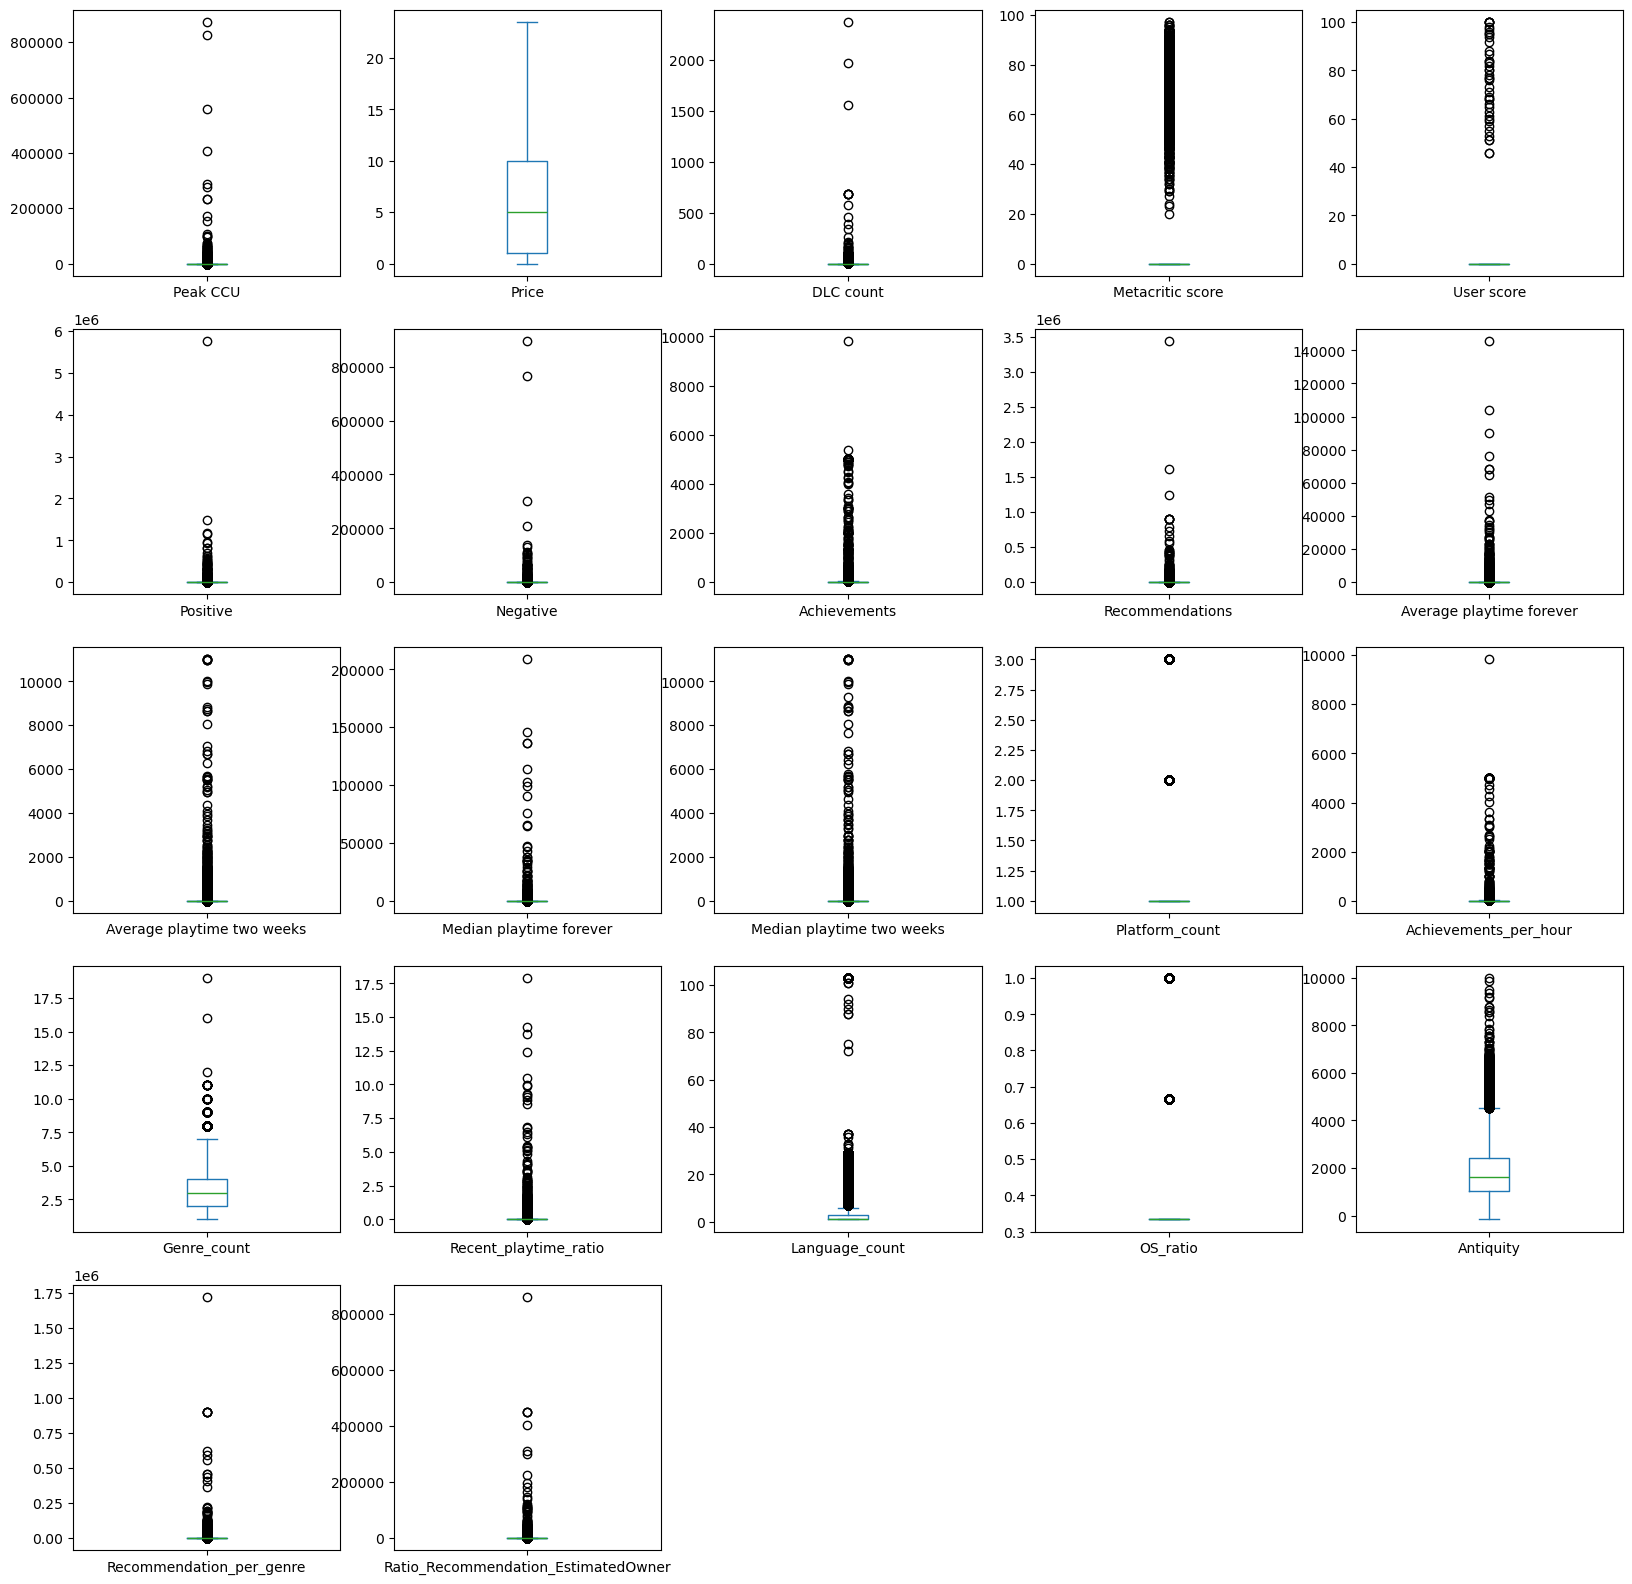

In [29]:
games_num.plot(kind = 'box', subplots = True, layout = (5, 5), figsize = (20, 20))
plt.show()

## Normalization

In [30]:
games_labels = games['Estimated owners'].copy()
games = games.drop('Estimated owners', axis = 1)

### Min-Max Scaler

In [31]:
minmax_columns = ['Price', 'OS_ratio', 'Platform_count']

In [32]:
minmax_scaler = MinMaxScaler()
games_minmax_scaled = minmax_scaler.fit_transform(games[minmax_columns])

In [33]:
minmax_df = pd.DataFrame(games_minmax_scaled, 
                          columns= minmax_scaler.get_feature_names_out())

### Robust Scaler

In [34]:
robust_columns = games_num.columns.to_list()

In [35]:
robust_scaler = RobustScaler()
games_robust_scaled = robust_scaler.fit_transform(games[robust_columns].drop(columns = minmax_columns))

In [36]:
robust_df = pd.DataFrame(games_robust_scaled, 
                         columns = robust_scaler.get_feature_names_out())

In [37]:
df_result = pd.concat((robust_df, minmax_df, games.drop(columns = robust_columns + minmax_columns)), axis = 1)

### Mutual Information

In [38]:
scores = scores_class(df_result, games_labels, discrete_features = 'auto')

In [39]:
scores

,Feature,MI Score (Classify)
4,Positive,4.010903e-01
5,Negative,3.519017e-01
16,Antiquity,2.518873e-01
18,Ratio_Recommendation_EstimatedOwner,1.956684e-01
8,Average playtime forever,1.861026e-01
10,Median playtime forever,1.838173e-01
19,Price,1.792970e-01
7,Recommendations,1.636429e-01
17,Recommendation_per_genre,1.611382e-01
12,Achievements_per_hour,1.309469e-01


In [40]:
drop_columns = scores[scores['MI Score (Classify)'] < 0.005]

In [41]:
df_result.drop(columns = drop_columns['Feature'].values, inplace = True)

### PCA

In [42]:
pca = PCA(n_components = 5)
principal_components = pca.fit_transform(df_result)

pca_df = pd.DataFrame(data=principal_components, columns=['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5'])

In [43]:
sum(pca.explained_variance_ratio_)

0.9994763122747123

In [44]:
pca_df.head(5)

,PCA1,PCA2,PCA3,PCA4,PCA5
0,-1048.928665,39.676387,55.074721,-148.211350,5.791417
1,-1048.943064,1.804625,11.734230,896.833978,17.341823
2,-572.110066,-49.467683,-37.884008,-36.257521,-3.104133
3,-1054.901531,-11.727810,17.641705,191.714187,8.307829
4,-1057.634952,-17.895085,20.392963,-132.059651,3.992041


In [45]:
# Calculate percentage variation
per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var) + 1)]

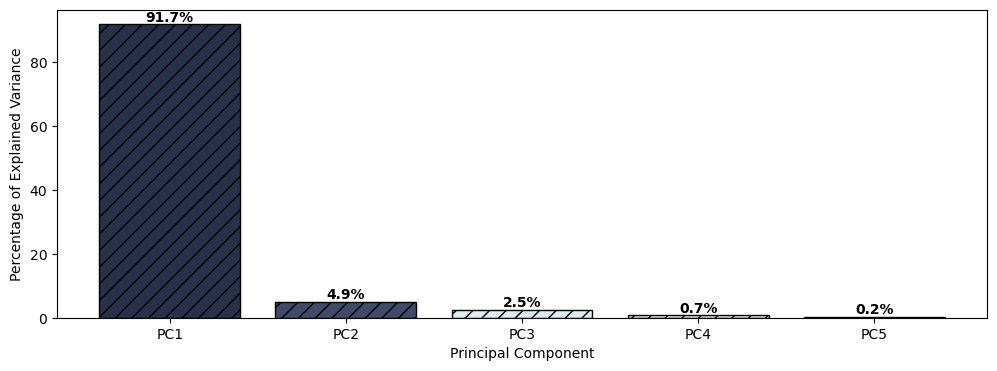

In [46]:
# Variance explained by each dimension
fig, ax = plt.subplots(figsize=(12, 4))
bars = ax.bar(x=range(1, len(per_var) + 1), height=per_var, tick_label=labels, color = colors, edgecolor='black', hatch='//')
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
for i, bar in enumerate(bars):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
            f'{per_var[i]}%', ha='center', va='bottom', color='black', fontweight='bold')
plt.show()

In [47]:
df_result = pd.concat((df_result, pca_df, games_labels), axis = 1)

# Save dataset

In [48]:
df_result.to_csv('../data/games_normalized_clean.csv', index = False)